In [1]:
import sys
print(sys.executable)

import numpy as np
from scipy.stats import rankdata, ttest_rel, ttest_1samp
from scipy.stats import zscore

from matplotlib import pyplot as plt
from scipy.stats import linregress
import pickle
import seaborn as sns

import nibabel as nib
subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
             'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
             'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
             'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
             'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
             'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
             'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
             'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
             'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
             'sub-6HW3V','sub-WF939']

Hippocampus_patterns = np.load(f'data/Hippocampus_patterns.npy')
VMPFC_patterns = np.load(f'data/VMPFC_patterns.npy')
PMC_patterns = np.load(f'data/PMC_patterns.npy')
AG_patterns = np.load(f'data/AG_patterns.npy')

/home/jwpark/anaconda3/envs/NarrativePuzzle/bin/python3.10


In [15]:
from scipy.spatial.distance import cosine

with open('../utils/movie/backward_retrieval_related.pkl', 'rb') as f:
    backward_retrieval_related = pickle.load(f)
with open('../utils/movie/backward_retrieval_unrelated.pkl', 'rb') as f:
    backward_retrieval_unrelated = pickle.load(f)

with open('../utils/movie/onset_retrieval_related.pkl', 'rb') as f:
    onset_retrieval_related = pickle.load(f)
with open('../utils/movie/onset_retrieval_unrelated.pkl', 'rb') as f:
    onset_retrieval_unrelated = pickle.load(f)

offset_range = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
duration_range = [1,3,5,7,9,11,13]
for roi in ['Hippocampus', 'VMPFC', 'PMC', 'AG']:
    backward_retrieval_related_results = np.zeros((len(offset_range),len(duration_range),len(subjects)))
    backward_retrieval_unrelated_results = np.zeros((len(offset_range),len(duration_range),len(subjects)))
    onset_retrieval_related_results = np.zeros((len(offset_range),len(duration_range),len(subjects)))
    onset_retrieval_unrelated_results = np.zeros((len(offset_range),len(duration_range),len(subjects)))
    for o, offset in enumerate(offset_range):
        print(f'{o+1}/{len(offset_range)}')
        for d, duration in enumerate(duration_range):
            backward_retrieval_related_result = np.zeros((len(subjects), len(backward_retrieval_related)))
            backward_retrieval_unrelated_result = np.zeros((len(subjects), len(backward_retrieval_unrelated)))
            onset_retrieval_related_result = np.zeros((len(subjects), len(onset_retrieval_related)))
            onset_retrieval_unrelated_result = np.zeros((len(subjects), len(onset_retrieval_unrelated)))

            for i, fname in enumerate(subjects):
                if roi == 'Hippocampus':
                    roi_patterns = Hippocampus_patterns[i,:,:] # time, voxel
                elif roi == 'PMC':
                    roi_patterns = PMC_patterns[i,:,:] # time, voxel
                elif roi == 'VMPFC':
                    roi_patterns = VMPFC_patterns[i,:,:] # time, voxel
                elif roi == 'AG':
                    roi_patterns = AG_patterns[i,:,:] # time, voxel

                for p, pair in enumerate(backward_retrieval_related):
                    if pair[0]+offset-duration//2 >= 0:
                        prev_patterns = roi_patterns[pair[0]+offset-duration//2:pair[0]+offset-duration//2+duration, :].mean(axis=0)
                    else:
                        prev_patterns = roi_patterns[0:pair[0]+offset-duration//2+duration, :].mean(axis=0)
                    next_patterns = roi_patterns[pair[1]-8:pair[1]-2, :].mean(axis=0) # Fixed from activity analysis
                    if np.isnan(prev_patterns).any() or np.isnan(next_patterns).any():
                        backward_retrieval_related_result[i,p] = np.nan
                    else:
                        backward_retrieval_related_result[i,p] = 1-cosine(prev_patterns, next_patterns)

                for p, pair in enumerate(backward_retrieval_unrelated):
                    if pair[0]+offset-duration//2 >= 0:
                        prev_patterns = roi_patterns[pair[0]+offset-duration//2:pair[0]+offset-duration//2+duration, :].mean(axis=0)
                    else:
                        prev_patterns = roi_patterns[0:pair[0]+offset-duration//2+duration, :].mean(axis=0)
                    next_patterns = roi_patterns[pair[1]-8:pair[1]-2, :].mean(axis=0) # Fixed from activity analysis
                    if np.isnan(prev_patterns).any() or np.isnan(next_patterns).any():
                        backward_retrieval_unrelated_result[i,p] = np.nan
                    else:
                        backward_retrieval_unrelated_result[i,p] = 1-cosine(prev_patterns, next_patterns)

                for p, pair in enumerate(onset_retrieval_related):
                    if pair[0]+offset-duration//2 >= 0:
                        prev_patterns = roi_patterns[pair[0]+offset-duration//2:pair[0]+offset-duration//2+duration, :].mean(axis=0)
                    else:
                        prev_patterns = roi_patterns[0:pair[0]+offset-duration//2+duration, :].mean(axis=0)
                    next_patterns = roi_patterns[pair[1]+3:pair[1]+7, :].mean(axis=0) # Fixed from activity analysis
                    if np.isnan(prev_patterns).any() or np.isnan(next_patterns).any():
                        onset_retrieval_related_result[i,p] = np.nan
                    else:
                        onset_retrieval_related_result[i,p] = 1-cosine(prev_patterns, next_patterns)

                for p, pair in enumerate(onset_retrieval_unrelated):
                    if pair[0]+offset-duration//2 >= 0:
                        prev_patterns = roi_patterns[pair[0]+offset-duration//2:pair[0]+offset-duration//2+duration, :].mean(axis=0)
                    else:
                        prev_patterns = roi_patterns[0:pair[0]+offset-duration//2+duration, :].mean(axis=0)
                    next_patterns = roi_patterns[pair[1]+3:pair[1]+7, :].mean(axis=0) # Fixed from activity analysis
                    if np.isnan(prev_patterns).any() or np.isnan(next_patterns).any():
                        onset_retrieval_unrelated_result[i,p] = np.nan
                    else:
                        onset_retrieval_unrelated_result[i,p] = 1-cosine(prev_patterns, next_patterns)

            backward_retrieval_related_result = np.nanmean(backward_retrieval_related_result, axis=-1)
            backward_retrieval_unrelated_result = np.nanmean(backward_retrieval_unrelated_result, axis=-1)
            onset_retrieval_related_result = np.nanmean(onset_retrieval_related_result, axis=-1)
            onset_retrieval_unrelated_result = np.nanmean(onset_retrieval_unrelated_result, axis=-1)

            backward_retrieval_related_results[o, d, :] = backward_retrieval_related_result
            backward_retrieval_unrelated_results[o, d, :] = backward_retrieval_unrelated_result
            onset_retrieval_related_results[o, d, :] = onset_retrieval_related_result
            onset_retrieval_unrelated_results[o, d, :] = onset_retrieval_unrelated_result

    np.save(f"data/{roi}_backward_retrieval_related_results.npy",backward_retrieval_related_results)
    np.save(f"data/{roi}_backward_retrieval_unrelated_results.npy", backward_retrieval_unrelated_results)
    np.save(f"data/{roi}_onset_retrieval_related_results.npy", onset_retrieval_related_results)
    np.save(f"data/{roi}_onset_retrieval_unrelated_results.npy", onset_retrieval_unrelated_results)

1/25
2/25


/tmp/ipykernel_178376/3306096150.py:42: RuntimeWarning: Mean of empty slice.
  prev_patterns = roi_patterns[0:pair[0]+offset-duration//2+duration, :].mean(axis=0)
/home/jwpark/anaconda3/envs/NarrativePuzzle/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/jwpark/anaconda3/envs/NarrativePuzzle/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_178376/3306096150.py:53: RuntimeWarning: Mean of empty slice.
  prev_patterns = roi_patterns[0:pair[0]+offset-duration//2+duration, :].mean(axis=0)


3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25
1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25
1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25
1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25


## Hippocampus

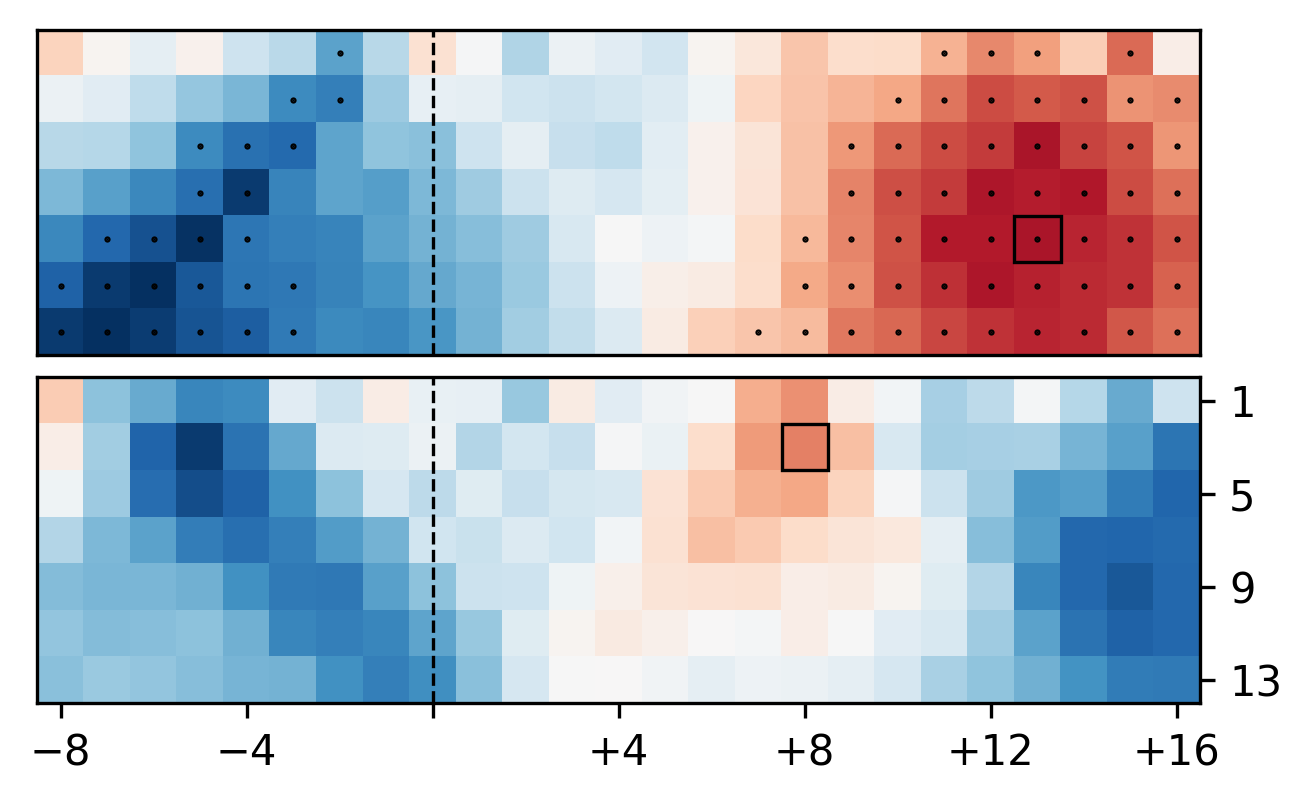

In [5]:
import matplotlib.patches as patches

roi = 'Hippocampus'
backward_retrieval_related_results = np.load(f"data/{roi}_backward_retrieval_related_results.npy")
backward_retrieval_unrelated_results = np.load(f"data/{roi}_backward_retrieval_unrelated_results.npy")
forward_retrieval_related_results = np.load(f"data/{roi}_forward_retrieval_related_results.npy")
forward_retrieval_unrelated_results = np.load(f"data/{roi}_forward_retrieval_unrelated_results.npy")

# average across subjects
backward_retrieval_related_mean = backward_retrieval_related_results.mean(axis=-1).T
forward_retrieval_related_mean = forward_retrieval_related_results.mean(axis=-1).T
backward_retrieval_related_significance = np.zeros(backward_retrieval_related_mean.T.shape)
forward_retrieval_related_significance = np.zeros(forward_retrieval_related_mean.T.shape)

offset_range = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
duration_range = [1,3,5,7,9,11]
for o, offset in enumerate(offset_range):
    for d, duration in enumerate(duration_range):
        _, p = ttest_rel(backward_retrieval_related_results[o,d,:], backward_retrieval_unrelated_results[o,d,:])
        backward_retrieval_related_significance[o,d] = p
        _, p = ttest_rel(forward_retrieval_related_results[o,d,:], forward_retrieval_unrelated_results[o,d,:])
        forward_retrieval_related_significance[o,d] = p

from statsmodels.stats.multitest import fdrcorrection
backward_retrieval_related_fdr, _ = fdrcorrection(backward_retrieval_related_significance.ravel())
backward_retrieval_related_fdr = backward_retrieval_related_fdr.reshape((len(offset_range),len(duration_range))).T
forward_retrieval_related_fdr, _ = fdrcorrection(forward_retrieval_related_significance.ravel())
forward_retrieval_related_fdr = forward_retrieval_related_fdr.reshape((len(offset_range),len(duration_range))).T

threshold = 0.03
plt.style.use('default')
fig, axes = plt.subplots(2,1,figsize=(5,3), dpi=300)
axes[0].imshow(backward_retrieval_related_mean, cmap='RdBu_r', vmin=-threshold, vmax=threshold)
axes[1].imshow(forward_retrieval_related_mean, cmap='RdBu_r', vmin=-threshold, vmax=threshold)

backward_retrieval_max_idx = np.unravel_index(np.argmax(backward_retrieval_related_mean), backward_retrieval_related_mean.shape)
forward_retrieval_max_idx = np.unravel_index(np.argmax(forward_retrieval_related_mean), forward_retrieval_related_mean.shape)

automax = True
if automax:
    x0 = backward_retrieval_max_idx[1]-0.5
    y0 = backward_retrieval_max_idx[0]-0.5
    x1 = forward_retrieval_max_idx[1]-0.5
    y1 = forward_retrieval_max_idx[0]-0.5
else:
    x0 = 15+8 - 0.5
    y0 = 4 - 0.5
    x1 = 7+8-0.5
    y1 = 4 - 0.5
axes[1].add_patch(
        patches.Rectangle(
            (x1, y1), 1, 1,
            edgecolor='k', linestyle='-',
            linewidth=0.8,
            fill=False, zorder=10, clip_on=False))
axes[0].add_patch(
        patches.Rectangle(
            (x0, y0), 1, 1,
            edgecolor='k', linestyle='-',
            linewidth=0.8,
            fill=False, zorder=10, clip_on=False))


axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([0, 4, 8, 12, 16, 20, 24])
axes[1].set_xticklabels(["−8","−4"," ", "+4", "+8", "+12", "+16"])
axes[1].set_yticks([0, 2, 4, 6])
axes[1].set_yticklabels(["1","5","9","13"])

for o, offset in enumerate(offset_range):
    for d, duration in enumerate(duration_range):
        if backward_retrieval_related_fdr[d,o]:
            axes[0].scatter(o,d, marker='.', s=1, c='k')
        if forward_retrieval_related_fdr[d,o]:
            axes[1].scatter(o,d, marker='.', s=1, c='k')

for ax in axes:
    ax.axvline(8, c='k', linestyle='--', lw=0.8)
    ax.yaxis.tick_right()
plt.subplots_adjust(hspace=0.005)
plt.show()

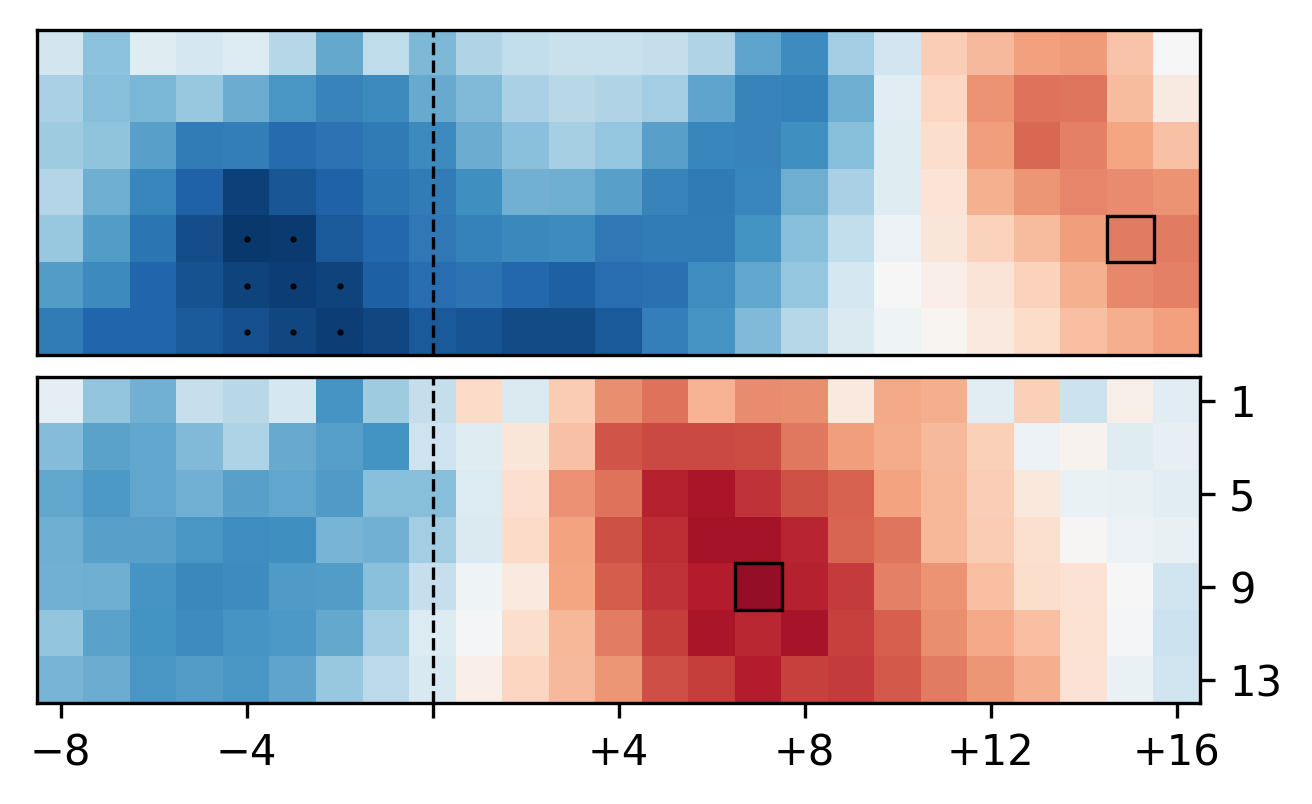

In [18]:
import matplotlib.patches as patches

roi = 'VMPFC'
backward_retrieval_related_results = np.load(f"data/{roi}_backward_retrieval_related_results.npy")
backward_retrieval_unrelated_results = np.load(f"data/{roi}_backward_retrieval_unrelated_results.npy")
forward_retrieval_related_results = np.load(f"data/{roi}_forward_retrieval_related_results.npy")
forward_retrieval_unrelated_results = np.load(f"data/{roi}_forward_retrieval_unrelated_results.npy")

# average across subjects
backward_retrieval_related_mean = backward_retrieval_related_results.mean(axis=-1).T
forward_retrieval_related_mean = forward_retrieval_related_results.mean(axis=-1).T
backward_retrieval_related_significance = np.zeros(backward_retrieval_related_mean.T.shape)
forward_retrieval_related_significance = np.zeros(forward_retrieval_related_mean.T.shape)

offset_range = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
duration_range = [1,3,5,7,9,11,13]
for o, offset in enumerate(offset_range):
    for d, duration in enumerate(duration_range):
        _, p = ttest_rel(backward_retrieval_related_results[o,d,:], backward_retrieval_unrelated_results[o,d,:])
        backward_retrieval_related_significance[o,d] = p
        _, p = ttest_rel(forward_retrieval_related_results[o,d,:], forward_retrieval_unrelated_results[o,d,:])
        forward_retrieval_related_significance[o,d] = p

from statsmodels.stats.multitest import fdrcorrection
backward_retrieval_related_fdr, _ = fdrcorrection(backward_retrieval_related_significance.ravel())
backward_retrieval_related_fdr = backward_retrieval_related_fdr.reshape((len(offset_range),len(duration_range))).T
forward_retrieval_related_fdr, _ = fdrcorrection(forward_retrieval_related_significance.ravel())
forward_retrieval_related_fdr = forward_retrieval_related_fdr.reshape((len(offset_range),len(duration_range))).T

threshold = 0.04
plt.style.use('default')
fig, axes = plt.subplots(2,1,figsize=(5,3), dpi=300)
axes[0].imshow(backward_retrieval_related_mean, cmap='RdBu_r', vmin=-threshold, vmax=threshold)
axes[1].imshow(forward_retrieval_related_mean, cmap='RdBu_r', vmin=-threshold, vmax=threshold)

backward_retrieval_max_idx = np.unravel_index(np.argmax(backward_retrieval_related_mean), backward_retrieval_related_mean.shape)
forward_retrieval_max_idx = np.unravel_index(np.argmax(forward_retrieval_related_mean), forward_retrieval_related_mean.shape)


x0 = 15+8 - 0.5
y0 = 4 - 0.5
x1 = 7+8-0.5
y1 = 4 - 0.5
axes[1].add_patch(
        patches.Rectangle(
            (x1, y1), 1, 1,
            edgecolor='k', linestyle='-',
            linewidth=0.8,
            fill=False, zorder=10, clip_on=False))
axes[0].add_patch(
        patches.Rectangle(
            (x0, y0), 1, 1,
            edgecolor='k', linestyle='-',
            linewidth=0.8,
            fill=False, zorder=10, clip_on=False))

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([0, 4, 8, 12, 16, 20, 24])
axes[1].set_xticklabels(["−8","−4"," ", "+4", "+8", "+12", "+16"])
axes[1].set_yticks([0, 2, 4, 6])
axes[1].set_yticklabels(["1","5","9","13"])

for o, offset in enumerate(offset_range):
    for d, duration in enumerate(duration_range):
        if backward_retrieval_related_fdr[d,o]:
            axes[0].scatter(o,d, marker='.', s=1, c='k')
        if forward_retrieval_related_fdr[d,o]:
            axes[1].scatter(o,d, marker='.', s=1, c='k')

for ax in axes:
    ax.axvline(8, c='k', linestyle='--', lw=0.8)
    ax.yaxis.tick_right()
plt.subplots_adjust(hspace=0.005)
plt.show()

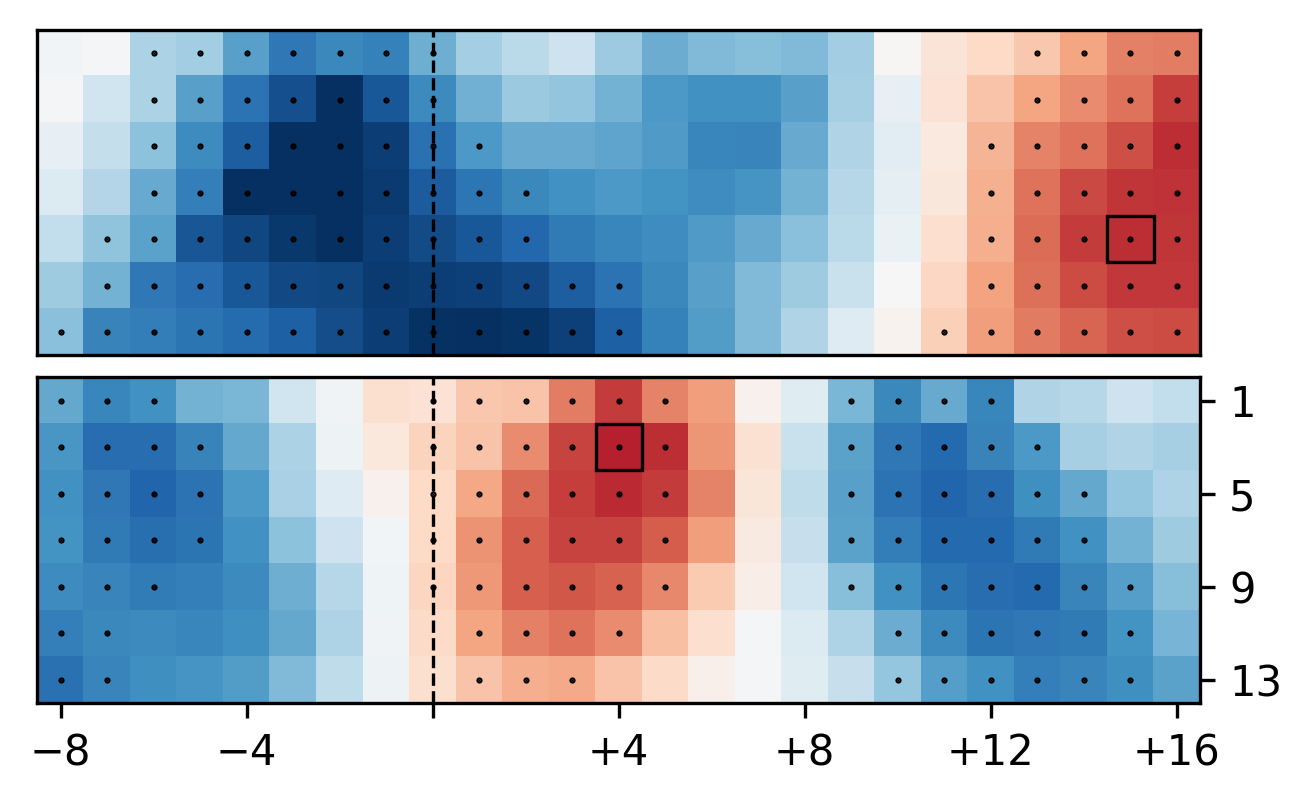

In [7]:
import matplotlib.patches as patches

roi = 'PMC'
backward_retrieval_related_results = np.load(f"data/{roi}_backward_retrieval_related_results.npy")
backward_retrieval_unrelated_results = np.load(f"data/{roi}_backward_retrieval_unrelated_results.npy")
forward_retrieval_related_results = np.load(f"data/{roi}_forward_retrieval_related_results.npy")
forward_retrieval_unrelated_results = np.load(f"data/{roi}_forward_retrieval_unrelated_results.npy")

# average across subjects
backward_retrieval_related_mean = backward_retrieval_related_results.mean(axis=-1).T
forward_retrieval_related_mean = forward_retrieval_related_results.mean(axis=-1).T
backward_retrieval_related_significance = np.zeros(backward_retrieval_related_mean.T.shape)
forward_retrieval_related_significance = np.zeros(forward_retrieval_related_mean.T.shape)

offset_range = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
duration_range = [1,3,5,7,9,11,13]
for o, offset in enumerate(offset_range):
    for d, duration in enumerate(duration_range):
        _, p = ttest_rel(backward_retrieval_related_results[o,d,:], backward_retrieval_unrelated_results[o,d,:])
        backward_retrieval_related_significance[o,d] = p
        _, p = ttest_rel(forward_retrieval_related_results[o,d,:], forward_retrieval_unrelated_results[o,d,:])
        forward_retrieval_related_significance[o,d] = p

from statsmodels.stats.multitest import fdrcorrection
backward_retrieval_related_fdr, _ = fdrcorrection(backward_retrieval_related_significance.ravel())
backward_retrieval_related_fdr = backward_retrieval_related_fdr.reshape((len(offset_range),len(duration_range))).T
forward_retrieval_related_fdr, _ = fdrcorrection(forward_retrieval_related_significance.ravel())
forward_retrieval_related_fdr = forward_retrieval_related_fdr.reshape((len(offset_range),len(duration_range))).T

threshold = 0.08
plt.style.use('default')
fig, axes = plt.subplots(2,1,figsize=(5,3), dpi=300)
axes[0].imshow(backward_retrieval_related_mean, cmap='RdBu_r', vmin=-threshold, vmax=threshold)
axes[1].imshow(forward_retrieval_related_mean, cmap='RdBu_r', vmin=-threshold, vmax=threshold)

backward_retrieval_max_idx = np.unravel_index(np.argmax(backward_retrieval_related_mean), backward_retrieval_related_mean.shape)
forward_retrieval_max_PMCidx = np.unravel_index(np.argmax(forward_retrieval_related_mean), forward_retrieval_related_mean.shape)

automax = True
if automax:
    x0 = backward_retrieval_max_idx[1]-0.5
    y0 = backward_retrieval_max_idx[0]-0.5
    x1 = forward_retrieval_max_idx[1]-0.5
    y1 = forward_retrieval_max_idx[0]-0.5
else:
    x0 = 15+8 - 0.5
    y0 = 4 - 0.5
    x1 = 7+8-0.5
    y1 = 4 - 0.5
axes[1].add_patch(
        patches.Rectangle(
            (x1, y1), 1, 1,
            edgecolor='k', linestyle='-',
            linewidth=0.8,
            fill=False, zorder=10, clip_on=False))
axes[0].add_patch(
        patches.Rectangle(
            (x0, y0), 1, 1,
            edgecolor='k', linestyle='-',
            linewidth=0.8,
            fill=False, zorder=10, clip_on=False))

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([0, 4, 8, 12, 16, 20, 24])
axes[1].set_xticklabels(["−8","−4"," ", "+4", "+8", "+12", "+16"])
axes[1].set_yticks([0, 2, 4, 6])
axes[1].set_yticklabels(["1","5","9","13"])

for o, offset in enumerate(offset_range):
    for d, duration in enumerate(duration_range):
        if backward_retrieval_related_fdr[d,o]:
            axes[0].scatter(o,d, marker='.', s=1, c='k')
        if forward_retrieval_related_fdr[d,o]:
            axes[1].scatter(o,d, marker='.', s=1, c='k')

for ax in axes:
    ax.axvline(8, c='k', linestyle='--', lw=0.8)
    ax.yaxis.tick_right()
plt.subplots_adjust(hspace=0.005)
plt.show()

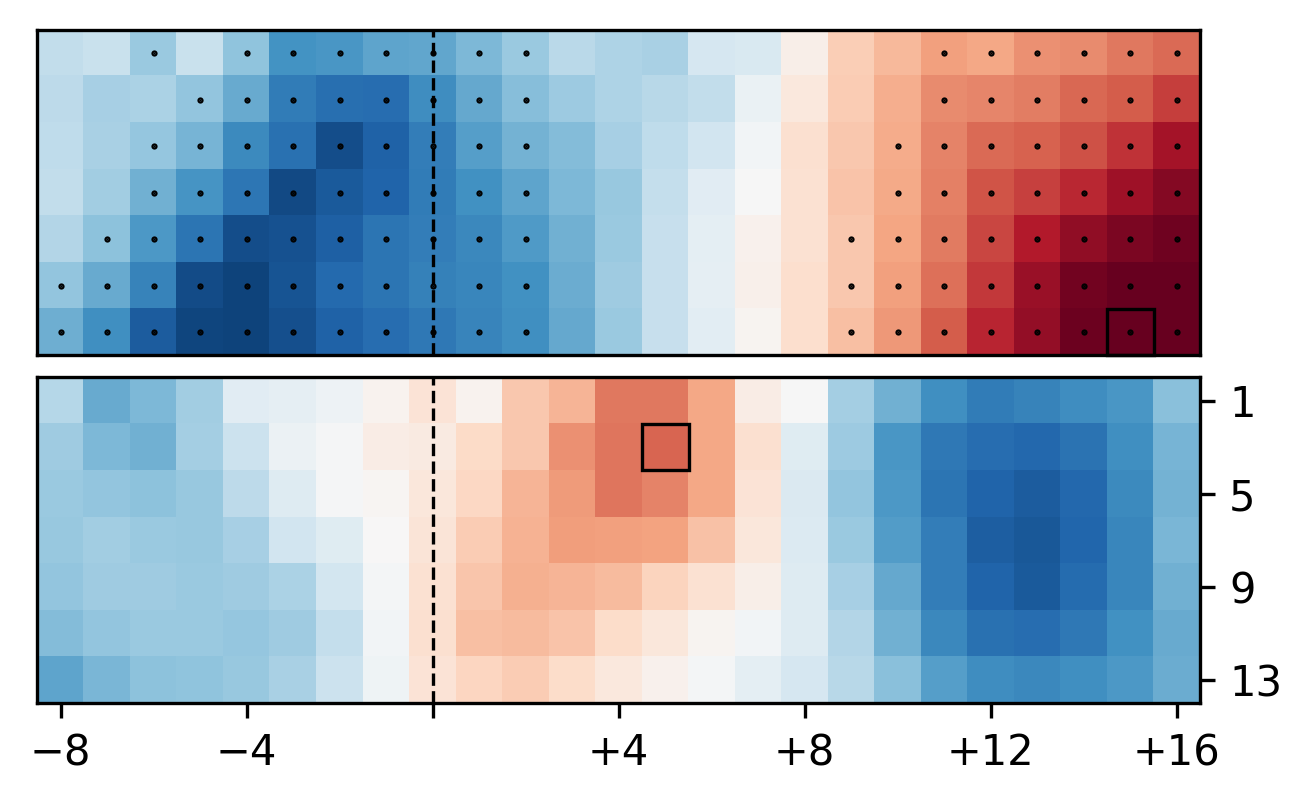

In [8]:
import matplotlib.patches as patches

roi = 'AG'
end_retrieval_related_results = np.load(f"data/{roi}_end_retrieval_related_results.npy")
end_retrieval_unrelated_results = np.load(f"data/{roi}_end_retrieval_unrelated_results.npy")
forward_retrieval_related_results = np.load(f"data/{roi}_forward_retrieval_related_results.npy")
forward_retrieval_unrelated_results = np.load(f"data/{roi}_forward_retrieval_unrelated_results.npy")

# average across subjects
end_retrieval_related_mean = end_retrieval_related_results.mean(axis=-1).T
forward_retrieval_related_mean = forward_retrieval_related_results.mean(axis=-1).T
end_retrieval_related_significance = np.zeros(end_retrieval_related_mean.T.shape)
forward_retrieval_related_significance = np.zeros(forward_retrieval_related_mean.T.shape)

offset_range = [-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
duration_range = [1,3,5,7,9,11,13]
for o, offset in enumerate(offset_range):
    for d, duration in enumerate(duration_range):
        _, p = ttest_rel(end_retrieval_related_results[o,d,:], end_retrieval_unrelated_results[o,d,:])
        end_retrieval_related_significance[o,d] = p
        _, p = ttest_rel(forward_retrieval_related_results[o,d,:], forward_retrieval_unrelated_results[o,d,:])
        forward_retrieval_related_significance[o,d] = p

from statsmodels.stats.multitest import fdrcorrection
end_retrieval_related_fdr, _ = fdrcorrection(end_retrieval_related_significance.ravel())
end_retrieval_related_fdr = end_retrieval_related_fdr.reshape((len(offset_range),len(duration_range))).T
forward_retrieval_related_fdr, _ = fdrcorrection(forward_retrieval_related_significance.ravel())
forward_retrieval_related_fdr = forward_retrieval_related_fdr.reshape((len(offset_range),len(duration_range))).T

threshold = 0.08
plt.style.use('default')
fig, axes = plt.subplots(2,1,figsize=(5,3), dpi=300)
axes[0].imshow(end_retrieval_related_mean, cmap='RdBu_r', vmin=-threshold, vmax=threshold)
axes[1].imshow(forward_retrieval_related_mean, cmap='RdBu_r', vmin=-threshold, vmax=threshold)

end_retrieval_max_idx = np.unravel_index(np.argmax(end_retrieval_related_mean), end_retrieval_related_mean.shape)
forward_retrieval_max_idx = np.unravel_index(np.argmax(forward_retrieval_related_mean), forward_retrieval_related_mean.shape)

automax = True
if automax:
    x0 = end_retrieval_max_idx[1]-0.5
    y0 = end_retrieval_max_idx[0]-0.5
    x1 = forward_retrieval_max_idx[1]-0.5
    y1 = forward_retrieval_max_idx[0]-0.5
else:
    x0 = 15+8 - 0.5
    y0 = 4 - 0.5
    x1 = 7+8-0.5
    y1 = 4 - 0.5
axes[1].add_patch(
        patches.Rectangle(
            (x1, y1), 1, 1,
            edgecolor='k', linestyle='-',
            linewidth=0.8,
            fill=False, zorder=10, clip_on=False))
axes[0].add_patch(
        patches.Rectangle(
            (x0, y0), 1, 1,
            edgecolor='k', linestyle='-',
            linewidth=0.8,
            fill=False, zorder=10, clip_on=False))

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([0, 4, 8, 12, 16, 20, 24])
axes[1].set_xticklabels(["−8","−4"," ", "+4", "+8", "+12", "+16"])
axes[1].set_yticks([0, 2, 4, 6])
axes[1].set_yticklabels(["1","5","9","13"])

for o, offset in enumerate(offset_range):
    for d, duration in enumerate(duration_range):
        if end_retrieval_related_fdr[d,o]:
            axes[0].scatter(o,d, marker='.', s=1, c='k')
        if forward_retrieval_related_fdr[d,o]:
            axes[1].scatter(o,d, marker='.', s=1, c='k')

for ax in axes:
    ax.axvline(8, c='k', linestyle='--', lw=0.8)
    ax.yaxis.tick_right()
plt.subplots_adjust(hspace=0.005)
plt.show()